In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import glob
import cv2

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
base_dir = '/Users/rushilrandhar/ml-p3/coe379L-sp25/datasets/unit03/Project3'
damage_dir = os.path.join(base_dir, 'damage')
no_damage_dir = os.path.join(base_dir, 'no_damage')

# Get list of image files
damage_files = glob.glob(os.path.join(damage_dir, '*.jpeg'))
no_damage_files = glob.glob(os.path.join(no_damage_dir, '*.jpeg'))

print(f"Number of damaged building images: {len(damage_files)}")
print(f"Number of non-damaged building images: {len(no_damage_files)}")

Number of damaged building images: 14170
Number of non-damaged building images: 7152


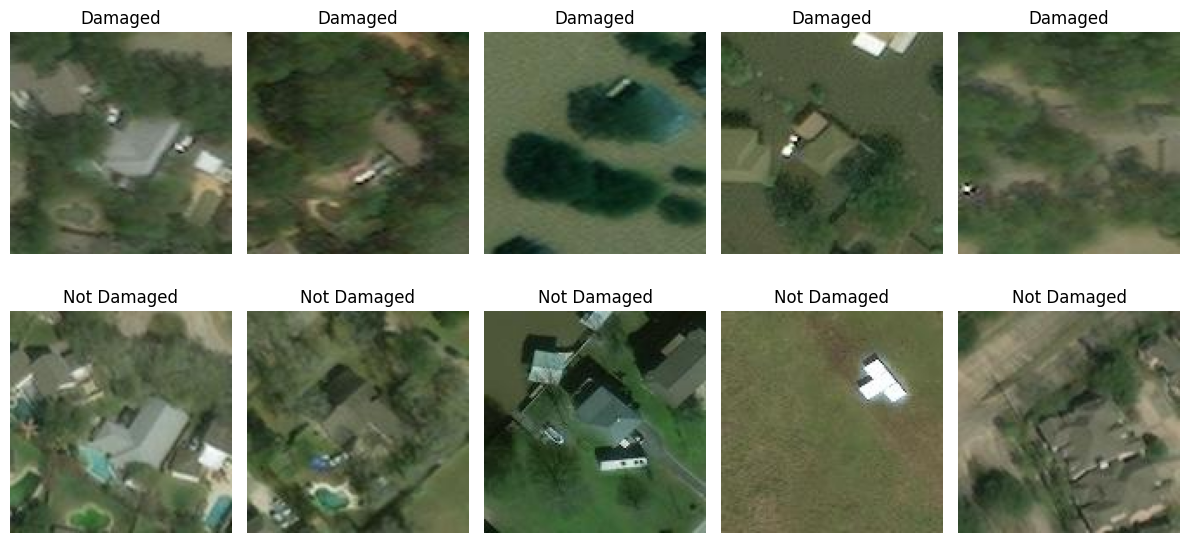

In [3]:
plt.figure(figsize=(12, 6))

# Sample damaged images
for i in range(5):
    plt.subplot(2, 5, i+1)
    img = load_img(damage_files[i], target_size=(128, 128))
    plt.imshow(img)
    plt.title('Damaged')
    plt.axis('off')

# Sample non-damaged images
for i in range(5):
    plt.subplot(2, 5, i+6)
    img = load_img(no_damage_files[i], target_size=(128, 128))
    plt.imshow(img)
    plt.title('Not Damaged')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
def get_image_properties(img_path):
    img = cv2.imread(img_path)
    height, width, channels = img.shape
    return height, width, channels

sample_damage_img = damage_files[0]
sample_no_damage_img = no_damage_files[0]

h_damage, w_damage, c_damage = get_image_properties(sample_damage_img)
h_no_damage, w_no_damage, c_no_damage = get_image_properties(sample_no_damage_img)

print(f"Damaged image dimensions: {h_damage}x{w_damage}x{c_damage}")
print(f"Non-damaged image dimensions: {h_no_damage}x{w_no_damage}x{c_no_damage}")

Damaged image dimensions: 128x128x3
Non-damaged image dimensions: 128x128x3


In [5]:
img_height, img_width = 128, 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)

x_batch, y_batch = next(train_generator)
print(f"Input shape: {x_batch.shape}")
print(f"Target shape: {y_batch.shape}")

Found 17058 images belonging to 2 classes.
Found 4264 images belonging to 2 classes.
Class indices: {'damage': 0, 'no_damage': 1}
Input shape: (32, 128, 128, 3)
Target shape: (32,)


In [6]:
def build_dense_model():
    model = Sequential([
        Flatten(input_shape=(img_height, img_width, 3)),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_lenet5_model():
    model = Sequential([
        Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(img_height, img_width, 3), padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, kernel_size=(5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# from paper
def build_alt_lenet5_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3), padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#train

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
]

def train_model(model, model_name):
    print(f"\nTraining {model_name}...")
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    val_loss, val_acc = model.evaluate(validation_generator)
    print(f"{model_name} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    return history, val_acc


In [ ]:
dense_model = build_dense_model()
dense_model.summary()
dense_history, dense_acc = train_model(dense_model, "Dense ANN")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,330,689 (96.63 MB)

 Trainable params: 25,330,689 (96.63 MB)

 Non-trainable params: 0 (0.00 B)


Training Dense ANN...
Epoch 1/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6025 - loss: 2.2593

534/534 ━━━━━━━━━━━━━━━━━━━━ 108s 201ms/step - accuracy: 0.6026 - loss: 2.2571 - val_accuracy: 0.6646 - val_loss: 0.6379
Epoch 2/20
 38/534 ━━━━━━━━━━━━━━━━━━━━ 1:31 184ms/step - accuracy: 0.6710 - loss: 0.6329

In [ ]:
lenet5_model = build_lenet5_model()
lenet5_model.summary()
lenet5_history, lenet5_acc = train_model(lenet5_model, "LeNet-5 CNN")

In [ ]:
alt_lenet5_model = build_alt_lenet5_model()
alt_lenet5_model.summary()
alt_lenet5_history, alt_lenet5_acc = train_model(alt_lenet5_model, "Alternate-LeNet-5 CNN")

In [ ]:
models = ["Dense ANN", "LeNet-5 CNN", "Alternate-LeNet-5 CNN"]
accuracies = [dense_acc, lenet5_acc, alt_lenet5_acc]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.title('Model Comparison - Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

In [ ]:
best_model_index = np.argmax(accuracies)
best_model_name = models[best_model_index]
print(f"The best performing model is: {best_model_name} with accuracy: {accuracies[best_model_index]:.4f}")

if best_model_index == 0:
    best_model = dense_model
elif best_model_index == 1:
    best_model = lenet5_model
else:
    best_model = alt_lenet5_model

best_model.save('best_hurricane_damage_model.h5')
print("Best model saved as 'best_hurricane_damage_model.h5'")

In [ ]:
validation_generator.reset()
y_pred = best_model.predict(validation_generator)
y_pred_binary = (y_pred > 0.5).astype(int)

validation_generator.reset()
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_binary)
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=class_names))